<a href="https://colab.research.google.com/github/rabee-alkourdi/XHateMARBERT/blob/main/XHateMARBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Experiment Preparation**
---

>### **1.1. Connect Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert the directory
import sys
sys.path.insert(0, '/content/drive/My Drive/Shared/Colab Notebooks/')

DATASETS_PATH     = sys.path[0] + 'Datasets'
MODELS_PATH       = sys.path[0] + 'Models'
LOGS_PATH         = sys.path[0] + "Models/Logs"
ATTRIBUTIONS_PATH = sys.path[0] + 'Attributions'

>### **1.2. Install required packages**

In [ ]:
!pip install -U transformers
!pip install -U sentencepiece
!pip install -U accelerate
!pip install -U datasets
!pip install -U evaluate
!pip install Keras-Preprocessing
!pip install demoji
!pip install captum
!pip install arabic_reshaper
!pip install python-bidi
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.99
    Uninstalling sentencepiece-0.1.99:
      Successfully uninstalled sentencepiece-0.1.99
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-non

>### **1.3. Set random seeds**

In [ ]:
import os
import numpy as np
import torch

os.environ['PYTHONHASHSEED'] = str(0)

RANDOM_SEED = 1381994

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from tensorflow import keras
keras.utils.set_random_seed(RANDOM_SEED)

import tensorflow as tf
from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1,
                                        inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(),
                            config = session_conf)
tf.compat.v1.keras.backend.set_session(sess)

>### **1.4. Import core packages**

In [ ]:
import pandas as pd
import copy
import pickle
import random
from tqdm.notebook import tqdm_notebook

from datasets import Dataset, DatasetDict, load_metric
from torch.utils.data import DataLoader

from transformers import (
    BertTokenizerFast,
    BertModel,
    BertForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

import evaluate

from captum.attr import visualization as capviz
from captum.attr._utils.visualization import VisualizationDataRecord
from captum.attr import LayerIntegratedGradients

import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Module for creating Word Clouds
from wordcloud import WordCloud

# Garbage Collection module (for clearing GPU memory)
import gc

# Modules for type hinting
from transformers.tokenization_utils_base import BatchEncoding
from collections.abc import Iterable
from torch import Tensor
from IPython.core.display import HTML

# Adding tqdm progress bars to pandas
tqdm_notebook.pandas()
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

## **2. Dataset Preparation**
---

>### **2.1. Load baseline datasets**

In [ ]:
import csv
from sklearn.model_selection import StratifiedShuffleSplit

def load_dataset(dataset_name):
    DS = dataset_name.upper()

    if DS == "OSACT":
        osact_train = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-train.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None,
            names = ["id", "tweet_text", "OFF_label", "HS_label",
                     "Vulgar_label", "Violence_label"],
            index_col = 0
        )
        osact_dev = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-dev.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None,
            names = ["id", "tweet_text", "OFF_label", "HS_label",
                     "Vulgar_label", "Violence_label"],
            index_col = 0
        )
        osact_test = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-test-tweets.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None,
            names=["id", "tweet_text"],
            index_col = 0
        )

        taskA_labels = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-test-taskA-gold-labels.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None
        )
        taskB_labels = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-test-taskB-gold-labels.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None
        )
        taskC_labels = pd.read_csv(
            f"{DATASETS_PATH}/{DS}/OSACT2022-sharedTask-test-taskC-gold-labels.txt",
            delimiter = "\t",
            quoting = csv.QUOTE_NONE,
            header = None
        )

        taskA_labels.index = osact_test.index
        taskB_labels.index = osact_test.index
        taskC_labels.index = osact_test.index

        osact_test['taskA_label'] = taskA_labels
        osact_test['taskB_label'] = taskB_labels
        osact_test['taskC_label'] = taskC_labels

        osact_train = osact_train[['tweet_text', 'HS_label']].rename(
            columns={'tweet_text': 'text', 'HS_label': 'label'})
        osact_dev = osact_dev[['tweet_text', 'HS_label']].rename(
            columns={'tweet_text': 'text', 'HS_label': 'label'})
        osact_test = osact_test[['tweet_text', 'taskB_label']].rename(
            columns={'tweet_text': 'text', 'taskB_label': 'label'})

        # Renaming all fine-grained HS labels to HS
        osact_train.loc[osact_train['label'] != 'NOT_HS', 'label'] = 'HS'
        osact_dev.loc[osact_dev['label'] != 'NOT_HS', 'label'] = 'HS'

        return osact_train, osact_dev, osact_test

    elif (DS == "LHSAB") | (DS == "THSAB"):
        if DS == "LHSAB":
            hsab = pd.read_excel(
                f"{DATASETS_PATH}/{DS}/L-HSAB-clean.xlsx",
                sheet_name="Tweets"
            )
        elif DS == "THSAB":
            hsab = pd.read_excel(
                f"{DATASETS_PATH}/{DS}/T-HSAB.xlsx"
            )

        # Create a boolean mask to filter rows with 'normal' and 'hate' in the 'Class' column
        class_mask = (hsab['Class'] == 'normal') | (hsab['Class'] == 'hate')
        hsab_binary = hsab[class_mask].sample(frac=1, random_state=RANDOM_SEED)

        # Specifiy features and labels
        X = hsab_binary['Tweet']  # Features
        y = hsab_binary['Class']  # Labels

        # Initialize StratifiedShuffleSplit with a 70/30 split
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)

        # Split the data into train, validation, and test indices
        for train_index, temp_index in sss.split(X, y):
            X_train, X_temp = X.iloc[train_index], X.iloc[temp_index]
            y_train, y_temp = y.iloc[train_index], y.iloc[temp_index]

        # Initialize another StratifiedShuffleSplit for the validation and test split
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.67, random_state=RANDOM_SEED)

        # Split the temp data into validation and test indices
        for valid_index, test_index in sss.split(X_temp, y_temp):
            X_valid, X_test = X_temp.iloc[valid_index], X_temp.iloc[test_index]
            y_valid, y_test = y_temp.iloc[valid_index], y_temp.iloc[test_index]

        hsab_train = pd.DataFrame({'text': X_train, 'label': y_train})
        hsab_dev = pd.DataFrame({'text': X_valid, 'label': y_valid})
        hsab_test = pd.DataFrame({'text': X_test, 'label': y_test})

        # Renaming all labels to be consistent with OSACT labels
        hsab_train.loc[hsab_train['label'] == 'normal', 'label'] = 'NOT_HS'
        hsab_train.loc[hsab_train['label'] == 'hate', 'label'] = 'HS'

        hsab_dev.loc[hsab_dev['label'] == 'normal', 'label'] = 'NOT_HS'
        hsab_dev.loc[hsab_dev['label'] == 'hate', 'label'] = 'HS'

        hsab_test.loc[hsab_test['label'] == 'normal', 'label'] = 'NOT_HS'
        hsab_test.loc[hsab_test['label'] == 'hate', 'label'] = 'HS'
        return hsab_train, hsab_dev, hsab_test

In [ ]:
DS_NAME = "LHSAB"
baseline_train, baseline_dev, baseline_test = load_dataset(DS_NAME)
print(f"Baseline Train size: {baseline_train.shape}")
print(f"Baseline Dev size: {baseline_dev.shape}")
print(f"Baseline Test size: {baseline_test.shape}")

Baseline Train size: (2820, 2)
Baseline Dev size: (398, 2)
Baseline Test size: (811, 2)


>### **2.2. Encode & Explore labels**

In [ ]:
# Encode labels
NOTHATE_LABEL = 0
HATE_LABEL = 1

# Mapping between label and id (to be used later when loading model)
id2label = {NOTHATE_LABEL: "NOT_HS", HATE_LABEL: "HS"}
label2id = {"NOT_HS": NOTHATE_LABEL, "HS": HATE_LABEL}

baseline_train['label'] = baseline_train['label'].replace(
    ('NOT_HS', 'HS'), (NOTHATE_LABEL, HATE_LABEL))
baseline_dev['label'] = baseline_dev['label'].replace(
    ('NOT_HS', 'HS'), (NOTHATE_LABEL, HATE_LABEL))
baseline_test['label'] = baseline_test['label'].replace(
    ('NOT_HS', 'HS'), (NOTHATE_LABEL, HATE_LABEL))

# Remove tweets less than 2 words
baseline_train = baseline_train[baseline_train['text'].str.split().str.len().gt(1)]

baseline_train.shape[0]

2802

In [ ]:
baseline_train['label'].value_counts()

label
0    2478
1     324
Name: count, dtype: int64

In [ ]:
baseline_test['label'].value_counts()

label
0    718
1     93
Name: count, dtype: int64

In [ ]:
# Extract Hate tweets for augmentation
baseline_hate = baseline_train.loc[baseline_train['label'] == HATE_LABEL]
print(f"Baseline hate size: {baseline_hate.shape[0]}")

# Extract Non-Hate tweets
baseline_non_hate = baseline_train.loc[baseline_train['label'] == NOTHATE_LABEL]
print(f"Baseline non-hate size: {baseline_non_hate.shape[0]}")

Baseline hate size: 324
Baseline non-hate size: 2478


In [ ]:
baseline_train.shape

(2802, 2)

## **3. Model Fine-Tuning**
---

>### **3.1. Create DatasetDict Object**

In [ ]:
dataset = DatasetDict({"train": Dataset.from_dict(baseline_train),
                       "validation": Dataset.from_dict(baseline_dev),
                       "test": Dataset.from_dict(baseline_test)})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2802
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 398
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 811
    })
})

>### **3.2. Tokenize Dataset**

In [ ]:
checkpoint = "UBC-NLP/MARBERT"
tokenizer = BertTokenizerFast.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
MAX_LENGTH = 64

def tokenize_text(example):
    model_inputs = tokenizer(
        text = example['text'],
        max_length = MAX_LENGTH,
        truncation = True
    )

    return model_inputs

In [ ]:
original_tokenized_dataset = dataset.map(
    tokenize_text,
    batched = True,
    desc = "Tokenizing dataset"
)

original_tokenized_dataset

Tokenizing dataset:   0%|          | 0/2802 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/398 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/811 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2802
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 398
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 811
    })
})

In [ ]:
tokenized_dataset = copy.deepcopy(original_tokenized_dataset)

>### **3.3. Use Attributions**

>>#### **3.3.1. Load IG Attributions**



In [ ]:
def load_attributions(name, target_label, norm):
    """
    Load attributions from a file

    Arguments:
        name: A string, name of the dataset attributions are for. i.e. (OSACT)
        target_label: A string, name of the label used to get attributions
        norm: A string, normalization method used
    Returns:
        attributions: A dictionary containing all attribution data
    """
    with open(
        f"{ATTRIBUTIONS_PATH}/{name}/{RANDOM_SEED}/"
        f"LIG_{name}_TRAIN_{target_label}_{norm}_{RANDOM_SEED}.pkl",
        'rb'
    ) as f:
        attributions = pickle.load(f)

    return attributions

In [ ]:
# Attributions of HS Tweets for HS Class
train_hs_none = load_attributions(DS_NAME, "HS", "NONE")
train_hs_seq  = load_attributions(DS_NAME, "HS", "SEQ")

>>#### **3.3.2. Historam of Attribution Maps**

>>>##### **3.3.2.1 Training Data - Attributions for HS-Class**

###### **HS Tweets**

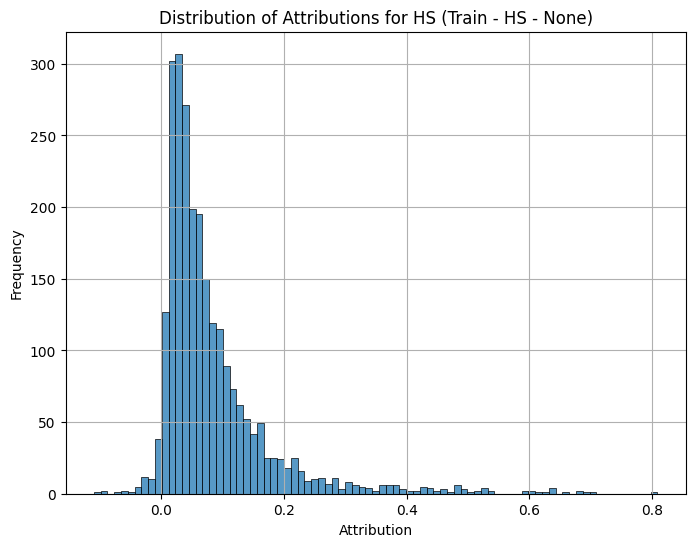

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_hs_none['vocab_attributions'].items()
    ]
)

plt.title('Distribution of Attributions for HS (Train - HS - None)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

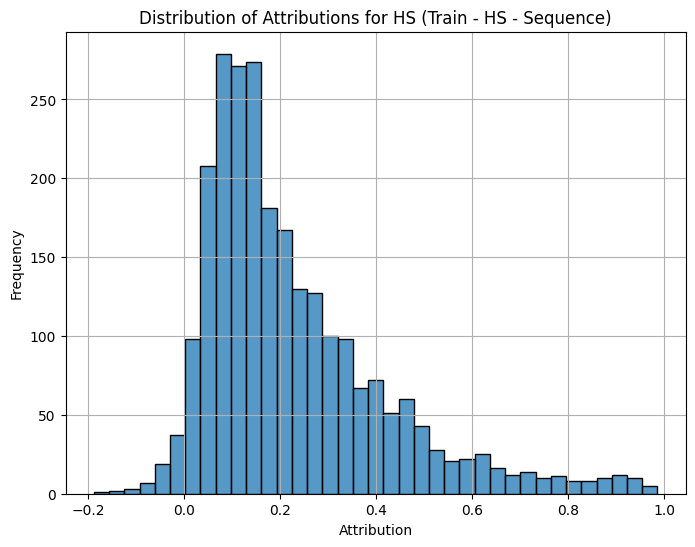

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_hs_seq['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for HS (Train - HS - Sequence)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

###### **NHS Tweets**

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_none['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for HS (Train - NHS - None)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_seq['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for HS (Train - NHS - Sequence)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_ds['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for HS (Train - NHS - Dataset)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

>>>##### **3.3.2.2 Training Data - Attributions for NHS-Class**

###### **HS Tweets**

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_hs_nhs_none['vocab_attributions'].items()
    ]
)

plt.title('Distribution of Attributions for NHS (Train - HS - None)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_hs_nhs_seq['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for NHS (Train - HS - Sequence)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_hs_nhs_ds['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for NHS (Train - HS - Dataset)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

###### **NHS Tweets**

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_nhs_none['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for NHS (Train - NHS - None)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_nhs_seq['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for NHS (Train - NHS - Sequence)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(
    [
        info['attribution']
        for _, info in train_nhs_nhs_ds['vocab_attributions'].items()
    ]
)
plt.title('Distribution of Attributions for NHS (Train - NHS - Dataset)')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

>>#### **3.3.3. Change Token Values**

>>>##### **3.3.3.1. Helper Functions**

In [ ]:
def filter_tokens(data, mode="absolute", value=0.0, top=True):
    """Filters tokens based on specified mode and value.

    Args:
        data (dict): Dictionary of tuples, each containing a pair of (token, {attribution, count}).
        mode (str, optional): Filtering mode, "absolute" or "percent". Defaults to "absolute".
        value (float, optional): Threshold value for filtering. Defaults to 0.0.
        top (bool, optional): Whether to filter top or bottom elements. Defaults to True (top).

    Returns:
        filtered_data: List of filtered tokens.
    """

    # Tokenize words and construct (tokens, attribution) pairs
    special_tokens = list(tokenizer.special_tokens_map.values())
    tokenized_data = []
    for word, info in data.items():
        # Skip special tokens
        if word not in special_tokens:
            tokenized_data.append((word, info['attribution']))

    # Sort data by attribution in descending order for efficient filtering
    sorted_data = sorted(tokenized_data, key=lambda x: x[1], reverse=True)

    filtered_data = []

    if mode == "absolute":
        # Filter based on absolute value comparison
        if top:
            # Keep tokens with attribution >= value
            filtered_data = [
                tokens
                for tokens, attr in sorted_data
                if attr >= value
            ]
        else:
            # Keep tokens with attribution <= value
            filtered_data = [
                tokens
                for tokens, attr in sorted_data
                if attr <= value
            ]

    elif mode == "percent":
        # Filter based on percentile
        if top:
            # Calculate number of top elements to keep
            num_to_keep = int(0.01 * value * len(sorted_data))
            # Keep top percentile of data
            filtered_data = [
                tokens
                for tokens, attr in sorted_data[:num_to_keep]
            ]
        else:
            # Calculate number of bottom elements to keep
            num_to_keep = int(0.01 * (100 - value) * len(sorted_data))
            # Keep bottom percentile of data
            filtered_data = [
                tokens
                for tokens, attr in sorted_data[num_to_keep:]
            ]

    return filtered_data

In [ ]:
def contains(big, small):
    """
    Checks if list 'big' contains the elements of list 'small' in the same order.

    Args:
        big: The larger list to search within.
        small: The smaller list to search for.

    Returns:
        A tuple containing the starting and ending indices of 'small' in 'big' if found,
        otherwise returns False.
    """
    matches = [] # Store all matching indices

    # Iterate through potential starting positions in big
    for i in range(len(big) - len(small) + 1):
        # Check each element in small against the corresponding element in big
        for j in range(len(small)):
            # Break if any element mismatches
            if big[i + j] != small[j]:
                break
        # If all elements match, append starting and ending indices
        else:
            matches.append((i, i + len(small)))

    return matches

In [ ]:
def get_ids(words):
    """
    Convert a list of words to a list of IDs (tokenize then convert to IDs)

    Args:
        words: A list of strings

    Returns:
        A list of IDs.
    """
    tokens = [tokenizer.tokenize(word) for word in words]
    ids = [tokenizer.convert_tokens_to_ids(token) for token in tokens]
    return ids

In [ ]:
def mask_tokens(sample, tokens):
    """Masks tokens with low attribution values in the sample's attention mask.

    Args:
        sample (dict): A sample containing 'attention_mask' and other relevant data.
        tokens (list): A list of ids of tokens to be masked.

    Returns:
        dict: The sample with its updated attention mask.
    """
    for token in tokens:
        matching_indices = contains(sample['input_ids'], token)
        if matching_indices:
            if sample['label'] == 1:
                print(f"SAMPLE: {tokenizer.decode(sample['input_ids'])}")
                print(f"TOKEN: {tokenizer.decode(token)}")
                print("------------------------------------------------")
                # print(f"{tokenizer.decode(sample['input_ids'])}")
        for start, end in matching_indices:
            sample['attention_mask'][start:end] = [0] * (end - start)

    return sample

In [ ]:
def remove_tokens(sample, tokens):
    """Removes tokens with low attribution values from the sample's input_ids,
    token_type_ids, and attention_mask, preserving the original token order.

    Args:
        sample (dict): A sample containing 'input_ids', 'token_type_ids',
                       and 'attention_mask' keys.
        tokens (list): A list of ids of token sequences to be removed.

    Returns:
        dict: The sample with the specified tokens removed.
    """
    sample['old_input_ids'] = copy.deepcopy(sample['input_ids'])
    for token in tokens:
        # Find start and end indices
        matching_indices = contains(sample['input_ids'], token)
        # Sort the indices in descending order to avoid overlapping deletions
        matching_indices.sort(reverse=True)
        if matching_indices:
            if sample['label'] == 0:
                print(f"Sample: {tokenizer.decode(sample['input_ids'])}")
                print(f"Token: {tokenizer.decode(token)}")
                print("------------------------------------------------")
        for start, end in matching_indices:
            # Remove the tokens
            sample['input_ids'] = (
                sample['input_ids'][:start]
                + sample['input_ids'][end:]
            )
            sample['token_type_ids'] = (
                sample['token_type_ids'][:start]
                + sample['token_type_ids'][end:]
            )
            sample['attention_mask'] = (
                sample['attention_mask'][:start]
                + sample['attention_mask'][end:]
            )

    return sample

In [ ]:
def replace_tokens(sample, old_tokens, new_tokens):
    """
    Replaces tokens with low attribution values in a sample with random tokens
    from the provided list.

    Args:
        sample (dict): A sample containing 'input_ids', 'token_type_ids',
                       and 'attention_mask' keys.
        old_tokens (list): A list of ids of token sequences to be replaced.
        new_tokens (list): A list of ids of token sequences to choose from for replacement.

    Returns:
        dict: The modified sample with replaced tokens.
    """
    sample['old_input_ids'] = copy.deepcopy(sample['input_ids'])
    for token in old_tokens:
        # Find all occurrences of the current token
        matching_indices = contains(sample['input_ids'], token)
        # Randomly choose a replacement token
        new_token = random.choice(new_tokens)
        # Sort the indices in descending order to avoid overlapping
        matching_indices.sort(reverse=True)
        if matching_indices:
            if sample['label'] == 0:
                print(f"SAMPLE: {tokenizer.decode(sample['input_ids'])}")
                print(f"OLD TOKEN: {tokenizer.decode(token)}")
                print(f"NEW TOKEN: {tokenizer.decode(new_token)}")
                print("------------------------------------------------")
        for start, end in matching_indices:
            # Perform Delete/Insert of Old/New tokens respectively
            sample['input_ids'] = (
                sample['input_ids'][:start]
                + new_token
                + sample['input_ids'][end:]
            )
            sample['token_type_ids'] = (
                sample['token_type_ids'][:start]
                + [0] * len(new_token)
                + sample['token_type_ids'][end:]
            )
            sample['attention_mask'] = (
                sample['attention_mask'][:start]
                + [1] * len(new_token)
                + sample['attention_mask'][end:]
            )

    return sample

>>>##### **3.3.3.2. Select Tokens**

In [ ]:
attributions_data = copy.deepcopy(train_hs_none['vocab_attributions'])

In [ ]:
fake_hs = filter_tokens(attributions_data, top=False)
print(f"Size of negative_tokens: {len(fake_hs)}")

Size of negative_tokens: 66


In [ ]:
bottom_hs_tokens = filter_tokens(attributions_data, 'percent', 10, False)
print(f"Size of bottom_hs_tokens: {len(bottom_hs_tokens)}")

In [ ]:
top_hs_tokens = filter_tokens(attributions_data, 'percent', 10)
print(f"Size of top_hs_tokens: {len(top_hs_tokens)}")

>>>##### **3.3.3.2. Apply Changes**

In [ ]:
tokenized_dataset = copy.deepcopy(original_tokenized_dataset)

In [ ]:
# selected_tokens = get_ids(fake_hs)
# selected_tokens = get_ids(top_hs_tokens)
# selected_tokens = get_ids(bottom_hs_tokens)
selected_tokens = copy.deepcopy(fake_hs)
# selected_tokens = copy.deepcopy(bottom_hs_tokens)

###### **Mask low attribution tokens**

In [ ]:
tokenized_dataset['train'] = tokenized_dataset['train'].map(
    mask_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Masking tokens in Train")

In [ ]:
tokenized_dataset['validation'] = tokenized_dataset['validation'].map(
    mask_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Masking tokens in Validation")

Masking tokens in Validation:   0%|          | 0/398 [00:00<?, ? examples/s]

SAMPLE: [CLS] انتقاما للمهاجرين لازم نبيد السوريين [SEP]
TOKEN: لازم
------------------------------------------------
SAMPLE: [CLS] اخ الحمدالله خسروا الكلاب هلا فيني موت بسلام [SEP]
TOKEN: هلا
------------------------------------------------
SAMPLE: [CLS] غريبين انتم اهل الجزيرة العربية بتجوا لتعايروا واحد بشكله بتشبهوه لكاين ظريف الشكل والاخلاق يا ريتكم تتعلموا من الكلاب وتصيروا ظريفين بدال الصلف والجلافة والاستعلاء [SEP]
TOKEN: والاخلاق
------------------------------------------------
SAMPLE: [CLS] هدول مستعدين يقتلوا الناس هيك شروي غروي لازم نقتلون كلن [SEP]
TOKEN: لازم
------------------------------------------------
SAMPLE: [CLS] انت كلكم تبع القوات بهايم او في جحاش وحمير وخواريف معكم هو وعم بدافع بسلاحو عن لبنان ضد اسراييل وضد التكفيرية وما خليتو سكين ما طعنتوا فيها ولو قادرين بالسلاح كنتو مستعدين تحاربوا اتدافعوا عن حبايبكم اسراييل وحلفايها هلا صار بدك يا يهاجم اسراييل والاه حيرتو سمانا انتو القو [SEP]
TOKEN: هلا
------------------------------------------------
SAMPLE: [CLS] ان

In [ ]:
tokenized_dataset['test'] = tokenized_dataset['test'].map(
    mask_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Masking tokens in Test")

###### **Remove low attribution tokens**

In [ ]:
tokenized_dataset['train'] = tokenized_dataset['train'].map(
    remove_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Removing tokens in Train")

In [ ]:
tokenized_dataset['validation'] = tokenized_dataset['validation'].map(
    remove_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Removing tokens in Validation")

In [ ]:
tokenized_dataset['test'] = tokenized_dataset['test'].map(
    remove_tokens,
    fn_kwargs={"tokens": selected_tokens},
    desc="Removing tokens in Test")

###### **Replace low attribution tokens**

In [ ]:
tokenized_dataset['train'] = tokenized_dataset['train'].map(
    replace_tokens,
    fn_kwargs={'old_tokens': selected_tokens,
               'new_tokens': get_ids(top_hs_tokens)},
    desc="Replacing tokens in Train")

In [ ]:
tokenized_dataset['validation'] = tokenized_dataset['validation'].map(
    replace_tokens,
    fn_kwargs={'old_tokens': selected_tokens,
               'new_tokens': get_ids(top_hs_tokens)},
    desc="Replacing tokens in Validation")

In [ ]:
tokenized_dataset['test'] = tokenized_dataset['test'].map(
    replace_tokens,
    fn_kwargs={'old_tokens': selected_tokens,
               'new_tokens': get_ids(top_hs_tokens)},
    desc="Replacing tokens in Test")

>>>##### **3.3.3.3. Synonyms Replacement**

###### **Load Model and Embeddings**

In [ ]:
trained_model_path = (
    f"{MODELS_PATH}/"
    f"MARBERT-finetuned-HateSpeech-{DS_NAME}-baseline-nopreprocessing-{RANDOM_SEED}"
)

trained_model = BertModel.from_pretrained(
    trained_model_path,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id)

# Load tokenizer
trained_tokenizer = BertTokenizerFast.from_pretrained(trained_model_path)

# Extract Embedding tensors
word_embeddings_tensors = {
    token: trained_model.get_input_embeddings()(torch.tensor(id))
    for token, id in trained_tokenizer.get_vocab().items()
}

# Extract Word Embeddings
word_embeddings = {
    key: value.detach().numpy()
    for key, value in word_embeddings_tensors.items()
}

###### **Initialize ANN Index & Function**

In [ ]:
from annoy import AnnoyIndex

# Initialize an Annoy index for word embeddings to perform
# Approximate Nearest Neighbors search. The index takes dimension (768 in the
# case of a BERT model) and a metric (here it's 'angualr'. aka cosine distance)
embedding_dim = trained_model.config.hidden_size
annoy_index = AnnoyIndex(embedding_dim, 'angular')

# Add embeddings to index
for word, embeddings in tqdm_notebook(word_embeddings.items(),
                                      desc="Adding Word Embeddings to Index"):
    annoy_index.add_item(
        tokenizer.convert_tokens_to_ids(word), # Word identifier (must be integer)
        embeddings.tolist() # Word Embeddings
    )

annoy_index.set_seed(RANDOM_SEED)

# Build a forest of n_trees
annoy_index.build(n_trees = 50)

Adding Word Embeddings to Index:   0%|          | 0/100000 [00:00<?, ?it/s]

True

In [ ]:
import nltk
from nltk.stem.isri import ISRIStemmer
from itertools import islice

stemmer = ISRIStemmer()

def get_similar_words(target_word, n, neighbors_num):

    # Tokenize target word
    tokens = trained_tokenizer.tokenize(target_word)

    # Get the embedding vectors for each token of target word
    tokens_embeddings = [word_embeddings[token] for token in tokens]

    # Average vectors if word has multiple tokens
    target_embeddings = []
    if len(target_embeddings) > 1:
        target_embeddings = np.mean(tokens_embeddings, axis=0)
    else:
        target_embeddings = tokens_embeddings[0]

    candidate_words_ids, distances = annoy_index.get_nns_by_vector(
        target_embeddings,
        n*neighbors_num,
        include_distances = True)

    raw_similarities = {
        tokenizer.convert_ids_to_tokens(id): 1-distance
        for id, distance in zip(candidate_words_ids, distances)}

    # Remove tokens that are emojis, numbers, 1-letter long,...
    similarities = {}
    for token, similarity in raw_similarities.items():
        if (token.isalpha()) & (len(token)>1):
            similarities[token] = similarity

    # Remove words that are too similar. i.e. if the original word is "كلاب",
    # don't accept "كلب", "والكلاب" etc
    target_stem = stemmer.stem(target_word)

    # Keep n unique similar word
    top_n_similar = list(
        islice(
            [word
             for word, similarity in similarities.items()
             if stemmer.stem(word) != target_stem],
            n
        )
    )

    return top_n_similar

###### **Define Contextual Operations**

In [ ]:
def contextual_augment(sample, candidates, n, neighbors_num):
    """Augments a sample by replacing high-saliency words with synonyms.

    Args:
        sample: A dictionary representing the original sample.
        candidates: A list of high-saliency words.
        n: The number of augmented samples to generate (default: 5).

    Returns:
        A list of augmented samples.
    """

    # Decode and split input_ids, filtering out special tokens if necessary
    decoded_sample = tokenizer.decode(
        sample['input_ids'], skip_special_tokens=True).split()

    # Find out synonyms for sample words that are in candidates
    synonyms = {
        word: get_similar_words(word, n, neighbors_num)
        for word in decoded_sample
        if word in candidates
    }

    # Create new copies of the original sample and replace
    # the hate words by new synonyms
    synonyms_samples = [decoded_sample.copy() for _ in range(n)]
    for word in synonyms.keys():
        word_index = decoded_sample.index(word)
        for sample_index, syn_sample in enumerate(synonyms_samples):
            syn_sample[word_index] = synonyms[word][sample_index]

    # Join strings into one string
    synonyms_samples = [" ".join(synonyms_samples[i]) for i in range(n)]

    # Create the final augmented sample and add it to list
    new_samples = []
    for i in range(n):
        new_sample = {}
        new_sample['text'] = synonyms_samples[i]
        new_sample['label'] = sample['label']
        new_sample['type'] = "CON_AUGMENT"
        new_sample['input_ids'] = tokenizer.encode(synonyms_samples[i])
        new_sample['token_type_ids'] = [0] * len(new_sample['input_ids'])
        new_sample['attention_mask'] = [1] * len(new_sample['input_ids'])
        new_samples.append(new_sample)

    return new_samples

In [ ]:
def contextual_replace(sample, candidates, n, neighbors_num):

    # Decode and split input_ids, filtering out special tokens if necessary
    decoded_sample = tokenizer.decode(
        sample['input_ids'], skip_special_tokens=True).split()

    # Find out synonyms for sample words that are in candidates
    synonyms = {
        word: get_similar_words(word, n, neighbors_num)
        for word in decoded_sample
        if word in candidates
    }
    sample['old_input_ids'] = copy.deepcopy(sample['input_ids'])
    # Check if there's a need to modify the sample
    if synonyms:
        # Modify Sample
        new_decoded_sample = decoded_sample.copy()
        for word in synonyms.keys():
            word_index = decoded_sample.index(word)

            new_decoded_sample[word_index] = random.choice(synonyms[word])

        # Join strings into one string
        synonyms_sample = " ".join(new_decoded_sample)

        new_sample = {}
        new_sample['text'] = synonyms_sample
        new_sample['label'] = sample['label']
        new_sample['input_ids'] = tokenizer.encode(synonyms_sample)
        new_sample['token_type_ids'] = [0] * len(new_sample['input_ids'])
        new_sample['attention_mask'] = [1] * len(new_sample['input_ids'])

        if sample['label'] == 1:
            print(f"OLD SAMPLE: {tokenizer.decode(sample['old_input_ids'])}")
            print(f"NEW SAMPLE: {tokenizer.decode(new_sample['input_ids'])}")
            print("------------------------------------------------")

        return new_sample
    else:
        return sample

###### **Run Contextual Operations**

###### **Augment**

In [ ]:
top_hs_words = filter_tokens(
    train_hs_seq['vocab_attributions'], mode="percent", value=40
)
bottom_hs_tokens = filter_tokens(
    train_hs_seq['vocab_attributions'], mode="percent", value=10, top=False
)

hs_words = list(set(top_hs_words+bottom_hs_tokens))
len(hs_words)

In [ ]:
new_hate_samples = []
for sample in tqdm_notebook(tokenized_dataset['train'], desc= "Augmenting"):
    if sample['label'] == 1:
        new_hate_samples.append(contextual_augment(sample, hs_words, 3, 3000))

# Flatten list
new_samples = [new_sample for sample_group in new_hate_samples for new_sample in sample_group]

In [ ]:
baseline_hate.shape[0]

In [ ]:
random.shuffle(new_samples)
selected_samples = random.sample(new_samples, 100)

In [ ]:
[sample['text'] for sample in selected_samples]

In [ ]:
for new_sample in tqdm_notebook(selected_samples, desc='Adding new samples to Dataset'):
    tokenized_dataset['train'] = tokenized_dataset['train'].add_item(new_sample)

tokenized_dataset['train'].shuffle(seed = RANDOM_SEED)

###### **Replace**

In [ ]:
tokenized_dataset['train'] = tokenized_dataset['train'].map(
    contextual_replace,
    fn_kwargs={"candidates": selected_tokens,
               "n": 5,
               "neighbors_num": 3000},
    desc="Replacing tokens in Train (CONTEXTUAL)")

Parameter 'function'=<function contextual_replace at 0x7d4d05761750> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Replacing tokens in Train (CONTEXTUAL):   0%|          | 0/2802 [00:00<?, ? examples/s]

OLD SAMPLE: [CLS] والله انك كذاب يا اصلع الراس والاخلاق بس ماقصر الزول نتف باقي الشعر … [SEP]
NEW SAMPLE: [CLS] والله انك كذاب يا اصلع الراس والانسانية بس ماقصر الزول نتف باقي الشعر … [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] حشرة سودانية اخوانية مهمتك نشر الكذب و العهر حذاء ايراني تموله قطراييل [SEP]
NEW SAMPLE: [CLS] حشرة سودانية اخوانية معركتنا نشر الكذب و العهر حذاء ايراني تموله قطراييل [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] اضرب والريح تصيح جنبلاط عثمان سعدو جعجع كلهم وصرمايتك سوا [SEP]
NEW SAMPLE: [CLS] اضرب والريح تصيح جنبلاط فاطمه سعدو جعجع كلهم وصرمايتك سوا [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] برافو هكذا انتم خواريف الزعيم وانت يا حسين خاااااروف ماااااء [SEP]
NEW SAMPLE: [CLS] برافو هكذا انتم خواريف الفريق وانت يا حسين خاااااروف ماااااء [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] معرفي قطر كل عمرى داعمي الارهاب لا بد من قطع يدهم [SEP]
NEW SAMPLE: [C

In [ ]:
tokenized_dataset['validation'] = tokenized_dataset['validation'].map(
    contextual_replace,
    fn_kwargs={"candidates": selected_tokens,
               "n": 5,
               "neighbors_num": 3000},
    desc="Replacing tokens in Validation (CONTEXTUAL)")

In [ ]:
tokenized_dataset['test'] = tokenized_dataset['test'].map(
    contextual_replace,
    fn_kwargs={"candidates": selected_tokens,
               "n": 5,
               "neighbors_num": 3000},
    desc="Replacing tokens in Validation (CONTEXTUAL)")

OLD SAMPLE: [CLS] مقاوم للناس المريضة هيدا صوص سوري اخي رضا او ايراني [SEP]
NEW SAMPLE: [CLS] مقاوم للناس المريضة هيدا صوص سوري اختي رضا او ايراني [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] لازم نبيد الغوطة كلها لازم نقتل كل سني لازم نقتل كل شخص رافض ظلم بشار الاسد [SEP]
NEW SAMPLE: [CLS] اكيد نبيد الغوطة كلها لازم نقتل كل سني لازم نقتل كل شخص رافض ظلم بشار الاسد [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] تغريدة وموضوع حلقة تافه ومبتذل متلك يافلاح يا ضيعجي ياحاقد طبقيا خمس سنين صامدة بالسنة اكتر من العلوي والقصدعن العدد وليس محبة البلد [SEP]
NEW SAMPLE: [CLS] تويته وموضوع حلقة تافه ومبتذل متلك يافلاح يا ضيعجي ياحاقد طبقيا خمس سنين صامدة بالسنة اكتر من العلوي والقصدعن العدد وليس محبة البلد [SEP]
------------------------------------------------
OLD SAMPLE: [CLS] لعنة الله عليك وعلى كل درزى خبيث تمارسون لعبة تبادل الادوار في لبنان درزى مع ودرزى ضد يهاجم وهذا داب اقليات الحقد الد [SEP]
NEW SAMPLE: [CLS] لعنة الله عليك وعلى كل درزى

>### **3.4. Load Pretrained Model**

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>### **3.5. Create Data Collator (Padding)**

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

>### **3.6. Define Training Parameters**

>>#### **3.6.1. Define Evaluation Metrics**

In [ ]:
def custom_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("f1", trust_remote_code=True)
    metric4 = evaluate.load("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = -1)

    precision = metric1.compute(
        predictions = predictions,
        references = labels,
        average = "macro")["precision"]

    recall = metric2.compute(
        predictions = predictions,
        references = labels,
        average = "macro")["recall"]

    f1 = metric3.compute(
        predictions = predictions,
        references = labels,
        average = "macro")["f1"]

    accuracy = metric4.compute(
        predictions = predictions,
        references = labels)["accuracy"]

    return {"precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy}

>>#### **3.6.2. Define Training Arguments**

In [ ]:
BATCH_SIZE = 128
CHECKPOINT_NAME = "Test"

training_args = TrainingArguments(
    output_dir                  = CHECKPOINT_NAME,
    logging_dir                 = f"{LOGS_PATH}/{CHECKPOINT_NAME}-{RANDOM_SEED}",
    overwrite_output_dir        = True,
    evaluation_strategy         = "epoch",

    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE,
    gradient_accumulation_steps = 4,
    optim                       = "adamw_torch",
    learning_rate               = 5e-5,
    weight_decay                = 0.01,
    num_train_epochs            = 20,
    warmup_steps                = 2,

    logging_strategy            = "epoch",
    save_strategy               = "epoch",
    save_total_limit            = 4,

    load_best_model_at_end      = True,
    metric_for_best_model       = "eval_f1",
    greater_is_better           = True,

    fp16                        = True,
    seed                        = RANDOM_SEED,
)

>>#### **3.6.3. Create Trainer**

In [ ]:
trainer = Trainer(
    model           = model,
    tokenizer       = tokenizer,
    args            = training_args,
    train_dataset   = tokenized_dataset["train"],
    eval_dataset    = tokenized_dataset["validation"],
    data_collator   = data_collator,
    compute_metrics = custom_metrics,
)

>### **3.7. Train Model**

In [ ]:
train_result = trainer.train()
train_result

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.628300,0.374608,0.442211,0.500000,0.469333,0.884422
2,0.247700,0.178581,0.856638,0.843071,0.849669,0.939698
4,0.066500,0.168071,0.873308,0.866230,0.869722,0.947236
6,0.018300,0.234890,0.856638,0.843071,0.849669,0.939698
8,0.013500,0.290856,0.916106,0.809536,0.852444,0.947236
10,0.006500,0.312513,0.861289,0.833622,0.846687,0.939698
12,0.004100,0.316186,0.880447,0.836462,0.856600,0.944724
14,0.004000,0.406881,0.809582,0.843997,0.825449,0.924623
16,0.003800,0.369543,0.848253,0.841650,0.844907,0.937186
18,0.014400,0.365536,0.856638,0.843071,0.849669,0.939698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=100, training_loss=0.07865446173585951, metrics={'train_runtime': 460.175, 'train_samples_per_second': 121.78, 'train_steps_per_second': 0.217, 'total_flos': 1244905847325600.0, 'train_loss': 0.07865446173585951, 'epoch': 18.181818181818183})

In [ ]:
import gc

del tokenizer
del model
del training_args
del trainer
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# Save model to Google Drive
trainer.save_model(f"{MODELS_PATH}/MARBERT-finetuned-HateSpeech-{DS_NAME}-baseline-nopreprocessing-{RANDOM_SEED}")
# trainer.save_model(f"TEST_MODEL")

## **4. Model Evaluation**
---

>#### **4.1. Test Model**

>>##### **4.1.1. Training Dataset**

In [ ]:
# Compute train metrics results
train_metrics = trainer.evaluate(eval_dataset = tokenized_dataset["train"])
train_metrics["train_samples"] = len(tokenized_dataset["train"])

# Save train metrics results
trainer.log_metrics("train", train_metrics)
#trainer.save_metrics("train", train_metrics)

***** train metrics *****
  epoch                   =    18.1818
  eval_accuracy           =     0.9925
  eval_f1                 =     0.9818
  eval_loss               =     0.0316
  eval_precision          =     0.9798
  eval_recall             =     0.9837
  eval_runtime            = 0:00:04.43
  eval_samples_per_second =    631.146
  eval_steps_per_second   =      4.955
  train_samples           =       2802


>>##### **4.1.2. Validation Dataset**

In [ ]:
# Compute evaluation metrics results
val_metrics = trainer.evaluate(eval_dataset = tokenized_dataset["validation"])
val_metrics["eval_samples"] = len(tokenized_dataset["validation"])

# Save evaluation metrics results
trainer.log_metrics("eval", val_metrics)
#trainer.save_metrics("eval", val_metrics)

***** eval metrics *****
  epoch                   =    18.1818
  eval_accuracy           =     0.9472
  eval_f1                 =     0.8697
  eval_loss               =     0.1681
  eval_precision          =     0.8733
  eval_recall             =     0.8662
  eval_runtime            = 0:00:03.67
  eval_samples            =        398
  eval_samples_per_second =    108.342
  eval_steps_per_second   =      1.089


>>##### **4.1.3. Test Dataset**

In [ ]:
# Compute Test metrics results
test_predictions, test_labels, test_metrics = trainer.predict(tokenized_dataset['test'])
test_metrics["test_samples"] = len(tokenized_dataset["test"])

# Save Test metrics results
trainer.log_metrics("test", test_metrics)
#trainer.save_metrics("test", test_metrics)

***** test metrics *****
  test_accuracy           =     0.9494
  test_f1                 =     0.8772
  test_loss               =     0.1484
  test_precision          =     0.8721
  test_recall             =     0.8825
  test_runtime            = 0:00:03.80
  test_samples            =        811
  test_samples_per_second =    212.871
  test_steps_per_second   =      1.837


>#### **4.1. Error Analysis**

In [ ]:
loaded_model = BertForSequenceClassification.from_pretrained(
    f"{MODELS_PATH}/MARBERT-finetuned-HateSpeech-{DS_NAME}-baseline-nopreprocessing-{RANDOM_SEED}",
    num_labels = 2,
    id2label = id2label,
    label2id = label2id)

loaded_trainer = Trainer(
    model           = loaded_model,
    tokenizer       = tokenizer,
    args            = training_args,
    train_dataset   = tokenized_dataset["train"],
    eval_dataset    = tokenized_dataset["validation"],
    data_collator   = data_collator,
    compute_metrics = custom_metrics,
)

In [ ]:
test_predictions, test_labels, test_metrics = trainer.predict(tokenized_dataset['test'])

In [ ]:
def analyse_errors(type, predictions, true_labels, data):
    samples = []

    # Get True Positive samples (HS classified as HS)
    if type == "TP":
        for idx, sample in enumerate(data):
            if (predictions[idx] == 1) & (true_labels[idx] == 1):
                samples.append(sample)

    # Get True Negative samples (HS classified as NOT_HS)
    elif type == "TN":
        for idx, sample in enumerate(data):
            if (predictions[idx] == 0) & (true_labels[idx] == 0):
                samples.append(sample)

    # Get False Positive samples (NOT_HS classified as HS)
    elif type == "FP":
        for idx, sample in enumerate(data):
            if (predictions[idx] == 1) & (true_labels[idx] == 0):
                samples.append(sample)

    # Get False Negative samples (HS classified as NOT_HS)
    elif type == "FN":
        for idx, sample in enumerate(data):
            if (predictions[idx] == 0) & (true_labels[idx] == 1):
                samples.append(sample)

    return samples

In [ ]:
preds = np.argmax(test_predictions, axis = -1)

tp_samples = analyse_errors("TP", preds, test_labels, tokenized_dataset["test"])
tn_samples = analyse_errors("TN", preds, test_labels, tokenized_dataset["test"])
fp_samples = analyse_errors("FP", preds, test_labels, tokenized_dataset["test"])
fn_samples = analyse_errors("FN", preds, test_labels, tokenized_dataset["test"])

print(f"TP count: {len(tp_samples)}")
print(f"TN count: {len(tn_samples)}")
print(f"FN count: {len(fn_samples)}")
print(f"FP count: {len(fp_samples)}")

In [ ]:
for idx, sample in enumerate(tp_samples):
    print(f"{tokenizer.decode(sample['old_input_ids'])}")

In [ ]:
for idx, sample in enumerate(tn_samples):
    print(f"{tokenizer.decode(sample['old_input_ids'])}")

In [ ]:
for idx, sample in enumerate(fn_samples):
    print(f"{tokenizer.decode(sample['old_input_ids'])}")

In [ ]:
for idx, sample in enumerate(fp_samples):
    print(f"{tokenizer.decode(sample['old_input_ids'])}")

## **5. Model Interpretability**
---

In [ ]:
# Select GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
explain_model_path = f"{MODELS_PATH}/MARBERT-finetuned-HateSpeech-{DS_NAME}-baseline-nopreprocessing-{RANDOM_SEED}"
# explain_model_path = "TEST_MODEL"

>### **Helper Functions**

In [ ]:
def tokenize_input_baseline(text: list) -> tuple[BatchEncoding, dict]:
    """
    A function that tokenizes and encodes Inputs/Baselines. The function
    constructs: Inputs/Baselines IDs, Inputs/Baselines Token Type IDs,
    Inputs/Baselines Position IDs, Inputs Attention Masks

    Arguments:
        text: Input text (tweets)

    Returns:
        input_tokens: Tokenized Input (IDs, Token Types, Positions, Attention Masks)
        baseline_tokens: Tokenized Baseline (IDs, Token Types, Positions)
    """

    # IDs of special [CLS], [PAD], and [SEP] tokens
    cls_token_id = tokenizer.cls_token_id # CLS token id ([CLS] in BERT= 2)
    pad_token_id = tokenizer.pad_token_id # PAD token id ([PAD] in BERT= 0)
    sep_token_id = tokenizer.sep_token_id # SEP token id ([SEP] in BERT= 3)

    # Create Input Token IDs,Input Token Type IDs, Input Attention Masks
    # Encode tokens and get Input IDs, Token Type IDs, and Attention Masks
    # Example: text = ['هذا مثال', 'لدينا ثلاث كلمات', 'ما هو تعريف الحياة']
    # (Ex) input_tokens = {'input_ids': [[2, 2158, 10941, 3, 0, 0],
    #                                   [2, 7686, 2902, 4796, 3, 0],
    #                                   [2, 1962, 2098, 15106, 2456, 3]],
    #                     'token_type_ids': [[0, 0, 0, 0, 0, 0],
    #                                        [0, 0, 0, 0, 0, 0],
    #                                        [0, 0, 0, 0, 0, 0]],
    #                     'attention_mask': [[1, 1, 1, 1, 0, 0],
    #                                        [1, 1, 1, 1, 1, 0],
    #                                        [1, 1, 1, 1, 1, 1]]}
    input_tokens = tokenizer(text, padding = True, return_tensors='pt')

    # Create Baseline Token IDs
    # Iterate through input_ids, then iterate through each encoded sequence (seq),
    # for each token (tok) in sequence (seq), construct a baseline token ids list
    # where each token is [PAD] unless it's [CLS] or [SEP].
    # Example: input_ids = [[2, 2158, 2538, 66249, 3, 0], [2, 512, 3, 0, 0]]
    # (Ex) base_input_ids= [[2,    0,    0,     0, 3, 0], [2,   0, 3, 0, 0]]
    base_input_ids = [
        [tok if tok in (cls_token_id, sep_token_id) else pad_token_id for tok in seq]
        for seq in input_tokens['input_ids']
    ]

    # Create Baseline Token Type IDs
    # (Ex) base_token_type_ids = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
    base_token_type_ids = [
        list(np.zeros(len(seq), dtype=int)) for seq in input_tokens['input_ids']
    ]

    # Create Position IDs for Inputs
    # They are used by the model to identify each token’s position in the list of tokens.
    # (Ex) position_ids = [[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]
    position_ids = [
        list(range(len(seq))) for seq in input_tokens['input_ids']
    ]
    # Add position ids to dict
    input_tokens['position_ids'] = torch.tensor(position_ids, dtype = torch.int64)

    # Create Position IDs for Baselines
    # (Ex) position_ids = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
    base_position_ids = [
        list(np.zeros(len(seq), dtype=int)) for seq in input_tokens['input_ids']
    ]

    # Create a dictionary to hold baseline tokens
    baseline_tokens = {}
    baseline_tokens['base_input_ids'] = torch.tensor(
        base_input_ids,
        dtype = torch.int64,
        device = device
    )
    baseline_tokens['base_token_type_ids'] = torch.tensor(
        base_token_type_ids,
        dtype = torch.int64,
        device = device
    )
    baseline_tokens['base_position_ids'] = torch.tensor(
        base_position_ids,
        dtype = torch.int64,
        device = device
    )

    return input_tokens, baseline_tokens

In [ ]:
def detokenize_input(sub_text_tokens: list, sub_sum_attributions: list) -> tuple[list, list]:
    """
    A function that detokenizes inputs that BERT tokenizer has broken into subwords.
    Subwords are combined back into words, and their attributions are added to form
    a single attribution per word

    Arguments:
        sub_text_tokens: Tokens (subwords) in textual format
        sub_sum_attributions: Summarized (subwords) attributions
    Returns:
        text_tokens: list of tokens after combining subwords
        sum_attributions: Summarized attributions after combining subwords
    """
    text_tokens = []
    sum_attributions = []
    for bidx, batch in enumerate(sub_text_tokens):

        new_batch_toks = []
        new_batch_attrs = []
        for sidx, sequence in enumerate(batch):

            new_seq_toks = []
            new_seq_attrs = []
            for idx, token in enumerate(sequence):
                # If token starts with ## (meaning it's part of previous token)
                if(token.startswith("##")):
                    # Pop last token added then combine it with current token
                    # after removing the ##
                    new_token = new_seq_toks.pop(-1) + token[2:]

                    # Pop last attribution added then add it to current token
                    # attribution
                    new_attr = new_seq_attrs.pop(-1) + sub_sum_attributions[bidx][sidx][idx]

                    # Add reconstructed token and its attribution to sequence lists
                    new_seq_toks.append(new_token)
                    new_seq_attrs.append(new_attr)
                # If token doesn't start with ##, just add it (and its attribution)
                # to the appropriate list
                else:
                    new_seq_toks.append(token)
                    new_seq_attrs.append(sub_sum_attributions[bidx][sidx][idx])
            new_batch_toks.append(new_seq_toks)
            new_batch_attrs.append(new_seq_attrs)

        text_tokens.append(new_batch_toks)
        sum_attributions.append(new_batch_attrs)

    return text_tokens, sum_attributions

In [ ]:
def create_token_attribution_pairs(norm_attributions: Tensor, text_tokens: list) -> list:
    """
    Create pairs of Token/Attribution

    Arguments:
        norm_attributions: Summarized & normalized attributions
        text_tokens: Tokens in textual format

    Returns:
        ta_pairs: A list of Token/Attribution pairs
    """
    ta_pairs = []
    for bidx, batch in enumerate(norm_attributions):
        b_text_tokens = text_tokens[bidx]
        for idx, seq_attrs in enumerate(batch):
            # Create a map of individual words and their attributions
            # This list contains duplicates
            pairs = [
                (b_text_tokens[idx][j], batch[idx][j]) for j in np.argsort(seq_attrs)
            ]
            ta_pairs.append(pairs)

    return ta_pairs

In [ ]:
def get_vocab_attributions(token_attribution_pairs: list) -> dict:
    """
    Filter Token/Attribution pairs to keep unique tokens (vocabulary)

    Arguments:
        token_attribution_pairs: A list of Token/Attribution pairs

    Returns:
        vocab_attribution_map: A dictionary of Token/Attribution
    """
    vocab_attribution_map = {}
    # Sort Token/Attribution pairs by highest attribution. In case of
    # duplicate token, only keep the highest attribution
    for batch in token_attribution_pairs:
        for token, attribution in batch:
            # Check if token already exists
            if token in vocab_attribution_map:
                # If it does, check if the current attribution is higher
                # than the stored one
                if attribution > vocab_attribution_map[token]['attribution']:
                    # If true, store the higher attribution
                    vocab_attribution_map[token]['attribution'] = attribution
                    # Increase token count by 1
                    vocab_attribution_map[token]['count'] += 1
            else:
                # If token is new
                vocab_attribution_map[token] = {'attribution': attribution,
                                                'count': 1}

    # Sort Token/Attribution pair in the dict by attribution (descending)
    sorted_map = sorted(
        vocab_attribution_map.items(), key=lambda item: -item[1]['attribution']
    )
    vocab_attribution_map = dict(sorted_map)

    return vocab_attribution_map

In [ ]:
def create_visualization_records(
    norm_attributions: Tensor,
    deltas: Tensor,
    predictions: Tensor,
    text_tokens: list,
    true_labels: list,
    target_label: int) -> list:
    """
    Create a visualization record for each entry in attributions

    Arguments:
        norm_attributions: Summarized and normalized attributions
        deltas: Convergence scores
        predictions: Predictions for inputs
        text_tokens: Tokens in textual format
        label: integer representing the class to attribute to

    Returns:
        vis_records: A list of visualization records
    """
    vis_records = []
    # Create visualization record for each text in batch and add to list
    for bidx, batch in enumerate(norm_attributions):
        for idx, seq_norm_attr in enumerate(batch):
            vis_records.append(capviz.VisualizationDataRecord(
                word_attributions = seq_norm_attr,
                pred_prob = torch.softmax(predictions[bidx][idx], dim = -1)[target_label],
                pred_class = id2label.get(torch.argmax(torch.softmax(predictions[bidx][idx], dim = -1)).item()),
                true_class = id2label.get(true_labels[bidx][idx].item()),
                attr_class = id2label.get(target_label),
                attr_score = sum(seq_norm_attr),
                raw_input_ids = text_tokens[bidx][idx],
                convergence_score = deltas[bidx][idx]))

    return vis_records

In [ ]:
def visualize_results(vis_records: list) -> HTML:
    """
    Print visualizations of attribution records

    Arguments:
        vis_records: A list of visualization records

    Returns:
        html_vis: Text visualization in HTML format
    """
    print('Visualize attributions based on Integrated Gradients')
    html_vis = capviz.visualize_text(vis_records)

    return html_vis

In [ ]:
def save_attributions(attributions, name, type, target_label, norm):
    """
    Save attributions in a file

    Arguments:
        attributions: A dictionary containing all attribution data
        name: A string, name of the dataset attributions are for. i.e. (OSACT)
        target_label: A string, name of the label used to get attributions
        norm: A string, normalization method used
    """

    with open(
        f"{ATTRIBUTIONS_PATH}/{name}/{RANDOM_SEED}/"
        f"LIG_{name}_{type}_{target_label}_{norm}_{RANDOM_SEED}.pkl",
        'wb'
    ) as f:
        pickle.dump(attributions, f)

In [ ]:
def load_attributions(name, type, target_label, norm):
    """
    Load attributions from a file

    Arguments:
        name: A string, name of the dataset attributions are for. i.e. (OSACT)
        target_label: A string, name of the label used to get attributions
        norm: A string, normalization method used
    Returns:
        attributions: A dictionary containing all attribution data
    """
    with open(
        f"{ATTRIBUTIONS_PATH}/{name}/{RANDOM_SEED}/"
        f"LIG_{name}_{type}_{target_label}_{norm}_{RANDOM_SEED}.pkl",
        'rb'
    ) as f:
        attributions = pickle.load(f)

    return attributions

>### **3.1. Layer Integrated Gradients**

In [ ]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    explain_model_path,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id)

model.to(device)  # Put model on GPU
model.zero_grad() # Clear model gradients
model.eval()      # Set model to evaluation mode

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained(explain_model_path)

>>#### **Core Functions**

In [ ]:
def lig_predict(inputs: Tensor,
                attention_mask: Tensor = None,
                token_type_ids: Tensor = None,
                position_ids: Tensor = None) -> Tensor:
    """
    Custom prediction function that returns logits only.

    Arguments:
        inputs: Tensor of batch Input IDs
        attention_mask: Tensor of batch Attention Masks
        token_type_ids: Tensor of batch Token Type IDs
        position_ids: Tensor of batch Position IDs

    Returns:
        A Tensor containing the logits of batch predictions
    """
    output = model(inputs,
                   attention_mask = attention_mask,
                   token_type_ids = token_type_ids,
                   position_ids = position_ids)

    return output['logits']

In [ ]:
def lig_forward(inputs: Tensor,
                attention_mask: Tensor = None,
                token_type_ids: Tensor = None,
                position_ids: Tensor = None) -> Tensor:
    """
    Custom forward function that uses Softmax function to convert predictions
    output to probability distribution for both classes.

    Arguments:
        inputs: Tensor of batch Input IDs
        attention_mask: Tensor of batch Attention Masks
        token_type_ids: Tensor of batch Token Type IDs
        position_ids: Tensor of batch Position IDs

    Returns:
        A Tensor containing the probabilities of each class
    """
    predictions = lig_predict(inputs, attention_mask, token_type_ids, position_ids)
    return torch.softmax(predictions, dim = 1)

In [ ]:
def lig_attribute(input_tokens: Tensor,
                  baseline_tokens: Tensor,
                  n_steps: int,
                  internal_batch_size: int,
                  label: int) -> tuple[list, Tensor, Tensor, list]:
    """
    Calculate the attributions of input tokens in label predictions.

    Arguments:
        input_tokens: Tokenized Input (IDs, Token Types, Positions, Attention Masks)
        baseline_tokens: Tokenized Baseline (IDs, Token Types, Positions)
        n_steps: Number of steps for attribution algorithm
        internal_batch_size: mini-batches size of attribution algorithm
        label: integer representing the class to attribute to

    Returns:
        sub_sum_attributions: Subword summarized attributions
        delta: Convergence score
        predictions: Predictions for the current batch
        sub_text_tokens: Subword tokens in textual format
    """

    # Convert Token IDs to Subword Tokens for visualization
    sub_text_tokens = [
        tokenizer.convert_ids_to_tokens(seq) for seq in input_tokens['input_ids']
    ]

    # Create LIG object and pass the custom forward function and model embeddings
    lig = LayerIntegratedGradients(
        forward_func = lig_forward,
        layer =  model.base_model.embeddings
    )

    # Caclulate attributions
    attributions, delta = lig.attribute(
        inputs = input_tokens['input_ids'],
        baselines = baseline_tokens['base_input_ids'],
        additional_forward_args = (input_tokens['attention_mask'],
                                   input_tokens['token_type_ids'],
                                   input_tokens['position_ids']),
        n_steps = n_steps,
        internal_batch_size = internal_batch_size,
        target = label,
        return_convergence_delta = True
    )

    # Predict
    predictions = lig_predict(
        input_tokens['input_ids'],
        input_tokens['attention_mask'],
        input_tokens['token_type_ids'],
        input_tokens['position_ids']
    )

    # Summarize subword attributions values (sum of values in each embedding dim)
    sub_sum_attributions_padded = attributions.sum(dim=-1)

    # Create a list to add summed attributions after removing [PAD]. We
    # create a new list instead of modifying the tensor because tensors
    # can't have varying length data
    sub_sum_attributions = []
    # Remove [PAD] tokens and their attributions
    for idx, seq in enumerate(sub_text_tokens):
        # Find out the first [PAD] index
        # if the sequence doesn't have [PAD], set pad_index to -1
        pad_index = seq.index('[PAD]') if '[PAD]' in seq else -1
        if pad_index != -1:
            # Modify tokens from [CLS] to [SEP]
            sub_text_tokens[idx] = seq[0:pad_index]
            # Add corresponding attributions
            sub_sum_attributions.append(sub_sum_attributions_padded[idx][0:pad_index])
        else:
            sub_sum_attributions.append(sub_sum_attributions_padded[idx])

    return sub_sum_attributions, delta, predictions, sub_text_tokens

In [ ]:
def lig_normalize(attributions: list, level: str = 'none') -> list:
    """
    Normalize attribution values (by row or by dataset)

    Arguments:
        attributions: list of summarized attributions.
        level: level of normalization.
            'none' : no normalization (default)
            'sequence':  normalize each sequence with regards to attributions
                 of that sequence only
            'dataset': normalize sequence with regards to the entire dataset

    Returns:
        norm_attributions: Normalized attribution values
    """
    norm_attributions = []

    if level == 'none':
        for batch in attributions:
            norms = [attrs for attrs in batch]
            norm_attributions.append(norms)

    if level == 'sequence':
        for batch in attributions:
            norms = [attrs / np.linalg.norm(attrs) for attrs in batch]
            norm_attributions.append(norms)

    elif level == 'dataset':
        flattened_sum_attrs = []
        [flattened_sum_attrs.extend(seq) for batch in attributions for seq in batch]

        for batch in attributions:
            norms = [attrs / np.linalg.norm(flattened_sum_attrs) for attrs in batch]
            norm_attributions.append(norms)

    return norm_attributions

In [ ]:
def normalize_all(basic_results: dict,
                  target_label: int = 1,
                  norm_level: str = 'none') -> dict:
    """
    Apply normalization to the attributions

    Arguments:
        data: A Dataset of texts
        target_label: integer representing the class to attribute to
        norm_level: level of normalization

    Returns:
        normalized_results: A dictionary containing all generated lists after
            specified normalization is applied
    """

    basic_dict = copy.deepcopy(basic_results)

    text_tokens = []
    sum_attributions = []
    token_attribution_pairs = []
    norm_attributions = []
    visualization_records = []

    # Combine subwords back into words
    text_tokens, sum_attributions = detokenize_input(
        basic_dict['sub_text_tokens'],
        basic_dict['sub_sum_attributions']
    )

    # Normalize attributions
    norm_attributions = lig_normalize(sum_attributions, norm_level)

    # Create visualization records for batch
    visualization_records = create_visualization_records(
        norm_attributions,
        basic_dict['deltas'],
        basic_dict['predictions'],
        text_tokens,
        basic_dict['true_labels'],
        target_label
    )

    # Create Token/Attribution pairs
    token_attribution_pairs = create_token_attribution_pairs(
        norm_attributions, text_tokens)

    # Create Vocab/Attributions
    vocab_attributions = get_vocab_attributions(token_attribution_pairs)

    # Create visualization records for batch
    visualization_records = create_visualization_records(
        norm_attributions,
        basic_dict['deltas'],
        basic_dict['predictions'],
        text_tokens,
        basic_dict['true_labels'],
        target_label
    )

    normalized_results = {
        'input_tokens': basic_dict['input_tokens'],
        'baseline_tokens': basic_dict['baseline_tokens'],
        'true_labels': basic_dict['true_labels'],
        'sub_sum_attributions': basic_dict['sub_sum_attributions'],
        'sum_attributions': sum_attributions,
        'deltas': basic_dict['deltas'],
        'predictions': basic_dict['predictions'],
        'sub_text_tokens': basic_dict['sub_text_tokens'],
        'text_tokens': text_tokens,
        'norm_attributions': norm_attributions,
        'token_attribution_pairs': token_attribution_pairs,
        'vocab_attributions': vocab_attributions,
        'visualization_records': visualization_records
    }

    return normalized_results

In [ ]:
def lig_interpret(data: Dataset,
                  target_label: int = 1,
                  batch_size: int = 1,
                  n_steps: int= 500,
                  internal_batch_size: int = 4) -> dict:
    """
    Interpret a dataset by calculating token attribution
    using Layer Integrated Gradients

    Arguments:
        data: A Dataset of texts
        target_label: integer representing the class to attribute to
        batch_size: size of mini-batches
        n_steps: Number of steps for attribution algorithm
        internal_batch_size: mini-batches size of attribution algorithm

    Returns:
        results: A dictionary containing all generated lists
    """
    # Create dataloader for batching
    dataloader = DataLoader(data, batch_size)

    input_tokens = []
    baseline_tokens = []
    true_labels = []
    sub_sum_attributions = []
    deltas = []
    predictions = []
    sub_text_tokens = []

    # Iterate through batches to calculate attributions
    for batch in tqdm_notebook(dataloader,
                               desc=f"Interpreting for {id2label[target_label]} class"):
        # Tokenize and Encode texts
        b_input_t, b_base_t = tokenize_input_baseline(batch['text'])
        b_input_t.to(device)

        # Calculate attributions
        b_sub_sum_attrs, b_delta, b_preds, b_sub_text_t = lig_attribute(
            b_input_t, b_base_t, n_steps, internal_batch_size, target_label)

        # Add batch tensors to appropriate list after detaching them
        # from computation graph (to help free GPU memory)
        input_tokens.append(
            {key: value.cpu().detach()
            for key, value in b_input_t.items()}
        )

        baseline_tokens.append(
            {key: value.cpu().detach()
            for key, value in b_base_t.items()}
        )

        true_labels.append(batch['label'].cpu().detach())

        sub_sum_attributions.append(
            [element.cpu().detach().tolist() for element in b_sub_sum_attrs]
        )

        deltas.append(b_delta.cpu().detach())
        predictions.append(b_preds.cpu().detach())
        sub_text_tokens.append(b_sub_text_t)

        # Batch cleanup to free GPU Memory
        del b_input_t, b_base_t, b_sub_sum_attrs, b_delta, b_preds
        torch.cuda.empty_cache()
        gc.collect()

    basic_results = {
        'input_tokens': input_tokens,
        'baseline_tokens': baseline_tokens,
        'true_labels': true_labels,
        'sub_sum_attributions': sub_sum_attributions,
        'deltas': deltas,
        'predictions': predictions,
        'sub_text_tokens': sub_text_tokens,
    }

    # End cleanup
    torch.cuda.empty_cache()
    gc.collect()

    return basic_results

>>#### **Train Dataset (HS)**

>>>##### **Calculate Attributions**

In [ ]:
baseline_hate['text'] = baseline_hate['text'].apply(lambda x: " ".join(x.split()[:64]))
hs_train_input = Dataset.from_dict(baseline_hate)
len(hs_train_input)

324

In [ ]:
hs_train_results = lig_interpret(
    hs_train_input,
    target_label = HATE_LABEL,
    batch_size = 64,
    n_steps= 500,
    internal_batch_size = 64)

# Save Basic results
# save_attributions(hs_train_results, DS_NAME, "TRAIN", "HS", "BASIC")

Interpreting for HS class:   0%|          | 0/6 [00:00<?, ?it/s]

>>>##### **Normalize Attributions**

In [ ]:
# Load Basic results
basic_results = load_attributions(DS_NAME,"TEST", "HS", "BASIC")

In [ ]:
# No normalization
hs_train_none = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'none'
)

# No normalization (sub-token level)
hs_train_none['sub_norm_attributions'] = lig_normalize(
    hs_train_none['sub_sum_attributions'],
    'none'
)

# Sequence-Level normalization
hs_train_seq = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'sequence'
)

# Sequence-Level normalization (sub-token level)
hs_train_seq['sub_norm_attributions'] = lig_normalize(
    hs_train_seq['sub_sum_attributions'],
    'sequence'
)

# Dataset-Level normalization
hs_train_ds = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'dataset'
)

# Sequence-Level normalization (sub-token level)
hs_train_ds['sub_norm_attributions'] = lig_normalize(
    hs_train_ds['sub_sum_attributions'],
    'dataset'
)

>>>##### **Save Attributions**

In [ ]:
# Save LIG Train (HS) Attributions (no normalization)
save_attributions(hs_train_none, DS_NAME, "TRAIN", "HS", "NONE")

# Save LIG Train (HS) Attributions (sequence normalization)
save_attributions(hs_train_seq, DS_NAME, "TRAIN", "HS", "SEQ")

# Save LIG Train (HS) Attributions (dataset normalization)
save_attributions(hs_train_ds, DS_NAME, "TRAIN", "HS", "DS")

>>>##### **Loading Attributions**

In [ ]:
# Load LIG Train (HS) Attributions (no normalization)
hs_train_none = load_attributions(DS_NAME, "TRAIN", "HS", "NONE")

# Load LIG Train (HS) Attributions (sequence normalization)
hs_train_seq = load_attributions(DS_NAME, "TRAIN", "HS", "SEQ")

# Load LIG Train (HS) Attributions (dataset normalization)
hs_train_ds = load_attributions(DS_NAME, "TRAIN", "HS", "DS")

>>>##### **Top K**

In [ ]:
hs_NONE_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_none['vocab_attributions'].items()
    if data['attribution'] > 0
]

hs_NONE_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_none['vocab_attributions'].items()
     if data['attribution'] < 0]

len(hs_NONE_positive), len(hs_NONE_negative)

(2439, 66)

In [ ]:
hs_SEQ_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_seq['vocab_attributions'].items()
    if data['attribution'] > 0]

hs_SEQ_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_seq['vocab_attributions'].items()
    if data['attribution'] < 0]

len(hs_SEQ_positive), len(hs_SEQ_negative)

(2439, 66)

In [ ]:
hs_DATA_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_ds['vocab_attributions'].items()
    if data['attribution'] > 0]

hs_DATA_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_ds['vocab_attributions'].items()
    if data['attribution'] < 0]

len(hs_DATA_positive), len(hs_DATA_negative)

(2439, 66)

In [ ]:
print("*****Top 10 Positive (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_NONE_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

*****Top 10 Positive (No Norm.)*****
-----------------------------------
Token       Attribution       Count
-----------------------------------
خراس	0.8085682701813821	1
حقودين	0.7063423951097278	1
وصخ	0.6953716578042024	1
الارهاب	0.6762378614657587	3
خواريف	0.6761529110464002	1
المعتوهين	0.6549066106435513	1
بهيمه	0.6421168732747353	1
الكلب	0.6369432957427033	3
الزباله	0.635295080389995	5
زق	0.6318504928857525	1


In [ ]:
print("*****Top 10 Negative (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_NONE_negative[0:10]:
    print(f"{token}\t{attr}\t{count}")

*****Top 10 Negative (No Norm.)*****
-----------------------------------
Token       Attribution       Count
-----------------------------------
رايك	-0.0002979740500705563	2
الطريق	-0.00043125364816468147	1
الشو	-0.0006137542144848824	1
لازم	-0.0009226428861515042	1
مارسيل	-0.001056935313069377	1
التفكير	-0.0010598487582517877	1
منفعة	-0.001267225000849144	1
قوه	-0.001577582242351409	1
حجة	-0.0018806859338852833	1
امين	-0.001884529906155708	1


In [ ]:
print("**Top 10 Positive (Sequence Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_SEQ_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

**Top 10 Positive (Sequence Norm.)**
-----------------------------------
Token       Attribution       Count
-----------------------------------
وصخ	0.9856736058324655	1
حقودين	0.9795592163332085	1
خواريف	0.9727063906069556	1
الارهاب	0.9590300239225089	3
كلاب	0.9564550563742573	4
الزباله	0.9512930272413357	4
المعتوهين	0.9479415143752468	1
الغباء	0.9405587344229719	1
والحمرنة	0.9380035366367346	1
متصهينين	0.935414449145905	1


In [ ]:
print("**Top 10 Positive (Dataset Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_DATA_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

**Top 10 Positive (Dataset Norm.)**
-----------------------------------
Token       Attribution       Count
-----------------------------------
خراس	0.10742088692725028	1
حقودين	0.09383985169240483	1
وصخ	0.09238235406967342	1
الارهاب	0.08984036788401722	3
خواريف	0.0898290819484582	1
المعتوهين	0.08700644282525238	1
بهيمه	0.08530728521248011	1
الكلب	0.08461995885109183	3
الزباله	0.08440098815737997	5
زق	0.0839433636642481	1


>>>##### **Save Visualizations as HTML**

In [ ]:
hs_train_html_none = visualize_results(hs_train_none['visualization_records'])
hs_train_html_seq = visualize_results(hs_train_seq['visualization_records'])
hs_train_html_ds = visualize_results(hs_train_ds['visualization_records'])

In [ ]:
with open('LHSAB_hs_train_html_none_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(hs_train_html_none.data)

with open('LHSAB_hs_train_html_seq_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(hs_train_html_seq.data)

with open('LHSAB_hs_train_html_ds_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(hs_train_html_ds.data)

>>>##### **Create Word Cloud**

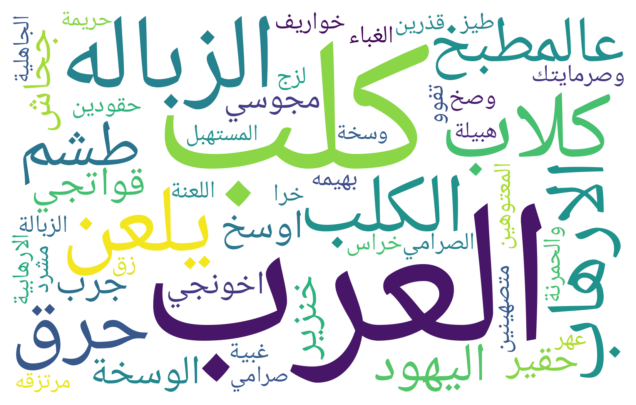

In [ ]:
# Step 1: Sort the data by 'count' values in descending order
sorted_data = sorted(hs_train_none['vocab_attributions'].items(), key=lambda x: x[1]['attribution'], reverse=True)

# Step 2: Select the top 50 items
top_50_data = sorted_data[:50]

# Step 3: Create a word cloud
wordcloud = WordCloud(font_path = sys.path[0] +'/utils/NotoNaskhArabic-Regular.ttf',
                      width=1600,
                      height=1000,
                      background_color='white')


# Generate the word cloud from the selected keys
wordcloud.generate_from_frequencies({key: value['count'] for key, value in top_50_data})

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
output_file = "LHSAB_TRAIN_HS_POSTIVE_" + str(RANDOM_SEED) + ".png"
wordcloud.to_file(output_file)

>>#### **Train Dataset (NOT_HS)**

>>>##### **Calculate Attributions**

In [ ]:
normal_train_ds = Dataset.from_dict(baseline_non_hate)

In [ ]:
normal_train_results = lig_interpret(
    normal_train_ds,
    target_label = HATE_LABEL,
    batch_size = 64,
    n_steps= 500,
    internal_batch_size = 64)

# Save Basic results
save_attributions(normal_train_results, DS_NAME, "NHS", "BASIC")

>>>##### **Normalize Attributions**

In [ ]:
# Load Basic results
basic_results = load_attributions(DS_NAME, "NHS", "BASIC")

In [ ]:
# No normalization
nhs_train_none = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'none'
)

# No normalization (sub-token level)
nhs_train_none['sub_norm_attributions'] = lig_normalize(
    nhs_train_none['sub_sum_attributions'],
    'none'
)

# Sequence-Level normalization
nhs_train_seq = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'sequence'
)

# Sequence-Level normalization (sub-token level)
nhs_train_seq['sub_norm_attributions'] = lig_normalize(
    nhs_train_seq['sub_sum_attributions'],
    'sequence'
)

# Dataset-Level normalization
nhs_train_ds = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'dataset'
)

# Sequence-Level normalization (sub-token level)
nhs_train_ds['sub_norm_attributions'] = lig_normalize(
    nhs_train_ds['sub_sum_attributions'],
    'dataset'
)

>>>##### **Save Attributions**

In [ ]:
# Save LIG Train (NHS) Attributions (no normalization)
save_attributions(nhs_train_none, DS_NAME, "NHS", "NONE")

# Save LIG Train (NHS) Attributions (sequence normalization)
save_attributions(nhs_train_seq, DS_NAME, "NHS", "SEQ")

# Save LIG Train (NHS) Attributions (dataset normalization)
save_attributions(nhs_train_ds, DS_NAME, "NHS", "DS")

>>>##### **Loading Attributions**

In [ ]:
# Load LIG Train (NHS) Attributions (no normalization)
nhs_train_none = load_attributions(DS_NAME, "TRAIN", "NHS", "NONE")

# Load LIG Train (NHS) Attributions (sequence normalization)
nhs_train_seq = load_attributions(DS_NAME, "TRAIN", "NHS", "SEQ")

# Load LIG Train (NHS) Attributions (dataset normalization)
nhs_train_ds = load_attributions(DS_NAME, "TRAIN", "NHS", "DS")

>>>##### **Top K**

In [ ]:
nhs_NONE_positive = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_none['vocab_attributions'].items()
    if data['attribution'] > 0
]

nhs_NONE_negative = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_none['vocab_attributions'].items()
     if data['attribution'] < 0]

len(nhs_NONE_positive), len(nhs_NONE_negative)

In [ ]:
nhs_SEQ_positive = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_seq['vocab_attributions'].items()
    if data['attribution'] > 0]

nhs_SEQ_negative = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_seq['vocab_attributions'].items()
    if data['attribution'] < 0]

len(nhs_SEQ_positive), len(nhs_SEQ_negative)

In [ ]:
nhs_DATA_positive = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_ds['vocab_attributions'].items()
    if data['attribution'] > 0]

nhs_DATA_negative = [
    (token, data['attribution'], data['count'])
    for token, data in nhs_train_ds['vocab_attributions'].items()
    if data['attribution'] < 0]

len(nhs_DATA_positive), len(nhs_DATA_negative)

In [ ]:
print("*****Top 10 Positive (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in nhs_NONE_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("*****Top 10 Negative (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in nhs_NONE_negative[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("**Top 10 Positive (Sequence Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in nhs_SEQ_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("**Top 10 Positive (Dataset Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in nhs_DATA_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

>>>##### **Save Visualizations as HTML**

In [ ]:
#supress output
%%capture

nhs_train_html_none = visualize_results(nhs_train_none['visualization_records'])
nhs_train_html_seq = visualize_results(nhs_train_seq['visualization_records'])
nhs_train_html_ds = visualize_results(nhs_train_ds['visualization_records'])

In [ ]:
with open('LHSAB_nhs_train_html_none_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(nhs_train_html_none.data)

with open('LHSAB_nhs_train_html_seq_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(nhs_train_html_seq.data)

with open('LHSAB_nhs_train_html_ds_' + str(RANDOM_SEED) + '.html', 'w') as f:
    f.write(nhs_train_html_ds.data)

>>>##### **Create Word Cloud**

In [ ]:
# Step 1: Sort the data by 'count' values in descending order
sorted_data = sorted(nhs_train_none['vocab_attributions'].items(), key=lambda x: x[1]['attribution'], reverse=True)

# Step 2: Select the top 50 items
top_50_data = sorted_data[:50]

# Step 3: Create a word cloud
wordcloud = WordCloud(font_path =sys.path[0] +'/utils/NotoNaskhArabic-Regular.ttf',
                      width=1600,
                      height=1000,
                      background_color='white')


# Generate the word cloud from the selected keys
wordcloud.generate_from_frequencies({key: value['count'] for key, value in top_50_data})

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
output_file = "LHSAB_TRAIN_NHS_POSTIVE_" + str(RANDOM_SEED) + ".png"
wordcloud.to_file(output_file)

>>#### **Error Analysis**

>>>##### **Calculate Attributions**

In [ ]:
text = 'مقاوم للناس المريضة هيدا صوص سوري اخي رضا او ايراني'
original_sample = tokenizer(text)
original_sample['label'] = 1
# mask_sample = mask_tokens(sample, get_ids(['لقاء']))
# remove_sample = remove_tokens(sample, get_ids(['لقاء']))

# replace_text = 'مقابلة الأقزام المعتوهين'
# replace_sample = tokenizer(text)
# replace_sample['label'] = 1
# replace_sample
txt = ["مقاوم للناس المريضة هيدا صوص سوري اخي رضا او ايراني"]
lbl = [1]

# dictionary of lists
dict1 = {'text': txt, 'label': lbl}

df = pd.DataFrame(dict1)
hs_train_input = Dataset.from_dict(df)

In [ ]:
hs_train_input = fn_samples
texts = [sample['text'] for sample in fn_samples]
labels = [1] * len(texts)
fn_dict = {'text': texts,
           'label': labels}
fn_dataset = pd.DataFrame(fn_dict)

In [ ]:
# xai_input = Dataset.from_dict(fn_dataset)
xai_input = Dataset.from_dict(baseline_test)

In [ ]:
xai_results = lig_interpret(
    xai_input,
    target_label = HATE_LABEL,
    batch_size = 64,
    n_steps= 500,
    internal_batch_size = 64)

# Save Basic results
save_attributions(xai_results, DS_NAME, "TEST", "HS", "BASIC")

>>>##### **Normalize Attributions**

In [ ]:
# Load Basic results
basic_results = load_attributions(DS_NAME, "TEST", "HS", "BASIC")

In [ ]:
# No normalization
hs_train_none = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'none'
)

# No normalization (sub-token level)
hs_train_none['sub_norm_attributions'] = lig_normalize(
    hs_train_none['sub_sum_attributions'],
    'none'
)

# Sequence-Level normalization
hs_train_seq = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'sequence'
)

# Sequence-Level normalization (sub-token level)
hs_train_seq['sub_norm_attributions'] = lig_normalize(
    hs_train_seq['sub_sum_attributions'],
    'sequence'
)

# Dataset-Level normalization
hs_train_ds = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'dataset'
)

# Sequence-Level normalization (sub-token level)
hs_train_ds['sub_norm_attributions'] = lig_normalize(
    hs_train_ds['sub_sum_attributions'],
    'dataset'
)

>>>##### **Save Attributions**

In [ ]:
# Save LIG Train (HS) Attributions (no normalization)
save_attributions(hs_train_none, DS_NAME, "TEST", "HS", "NONE")

# Save LIG Train (HS) Attributions (sequence normalization)
save_attributions(hs_train_seq, DS_NAME, "TEST",  "HS", "SEQ")

# Save LIG Train (HS) Attributions (dataset normalization)
save_attributions(hs_train_ds, DS_NAME, "TEST",  "HS", "DS")

>>>##### **Loading Attributions**

In [ ]:
# Load LIG Train (HS) Attributions (no normalization)
hs_train_none = load_attributions(DS_NAME, "TEST",  "HS", "NONE")

# Load LIG Train (HS) Attributions (sequence normalization)
hs_train_seq = load_attributions(DS_NAME, "TEST",  "HS", "SEQ")

# Load LIG Train (HS) Attributions (dataset normalization)
hs_train_ds = load_attributions(DS_NAME, "TEST",  "HS", "DS")

>>>##### **Top K**

In [ ]:
hs_NONE_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_none['vocab_attributions'].items()
    if data['attribution'] > 0
]

hs_NONE_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_none['vocab_attributions'].items()
     if data['attribution'] < 0]

len(hs_NONE_positive), len(hs_NONE_negative)

In [ ]:
hs_SEQ_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_seq['vocab_attributions'].items()
    if data['attribution'] > 0]

hs_SEQ_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_seq['vocab_attributions'].items()
    if data['attribution'] < 0]

len(hs_SEQ_positive), len(hs_SEQ_negative)

In [ ]:
hs_DATA_positive = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_ds['vocab_attributions'].items()
    if data['attribution'] > 0]

hs_DATA_negative = [
    (token, data['attribution'], data['count'])
    for token, data in hs_train_ds['vocab_attributions'].items()
    if data['attribution'] < 0]

len(hs_DATA_positive), len(hs_DATA_negative)

In [ ]:
print("*****Top 10 Positive (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_NONE_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("*****Top 10 Negative (No Norm.)*****")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_NONE_negative[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("**Top 10 Positive (Sequence Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_SEQ_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

In [ ]:
print("**Top 10 Positive (Dataset Norm.)**")
print("-----------------------------------")
print("Token       Attribution       Count")
print("-----------------------------------")
for token, attr, count in hs_DATA_positive[0:10]:
    print(f"{token}\t{attr}\t{count}")

## **MANUAL Interpretability**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# explain_model_path = f"{MODELS_PATH}/MARBERT-finetuned-HateSpeech-{DS_NAME}-baseline-nopreprocessing-{RANDOM_SEED}"
explain_model_path = "TEST_MODEL"
model = BertForSequenceClassification.from_pretrained(
    explain_model_path,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id)

model.to(device)  # Put model on GPU
model.zero_grad() # Clear model gradients
model.eval()      # Set model to evaluation mode

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained(explain_model_path)

In [ ]:
txt = ["الله يلعن الاخوان المسلمين و بلي بذرهم للمرة الالف على التوالي اناشد وزير كوريا الشمالية المحترم كيم …"]
lbl = [1]

# dictionary of lists
dict1 = {'text': txt, 'label': lbl}

df = pd.DataFrame(dict1)
hs_train_input = Dataset.from_dict(df)

dataloader = DataLoader(hs_train_input, 64)

In [ ]:
for batch in dataloader:
    input_tokens = tokenizer(batch['text'], padding = True, return_tensors='pt')
    for idx, tok in enumerate(input_tokens['input_ids'][0]):
        print(f"{idx}: {tok} ({tokenizer.decode(tok)})")

In [ ]:
input_tokens['attention_mask'][0][3] = 0
input_tokens['attention_mask'][0][4] = 0

In [ ]:
cls_token_id = tokenizer.cls_token_id
pad_token_id = tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

base_input_ids = [
    [tok if tok in (cls_token_id, sep_token_id) else pad_token_id for tok in seq]
    for seq in input_tokens['input_ids']
]

base_token_type_ids = [
    list(np.zeros(len(seq), dtype=int)) for seq in input_tokens['input_ids']
]

position_ids = [
    list(range(len(seq))) for seq in input_tokens['input_ids']
]
input_tokens['position_ids'] = torch.tensor(position_ids, dtype = torch.int64)

base_position_ids = [
    list(np.zeros(len(seq), dtype=int)) for seq in input_tokens['input_ids']
]

baseline_tokens = {}
baseline_tokens['base_input_ids'] = torch.tensor(
    base_input_ids,
    dtype = torch.int64,
    device = device
)
baseline_tokens['base_token_type_ids'] = torch.tensor(
    base_token_type_ids,
    dtype = torch.int64,
    device = device
)
baseline_tokens['base_position_ids'] = torch.tensor(
    base_position_ids,
    dtype = torch.int64,
    device = device
)
####################################################################
input_tokens.to(device)
####################################################################
sub_text_tokens = [
    tokenizer.convert_ids_to_tokens(seq) for seq in input_tokens['input_ids']
]
####################################################################
lig = LayerIntegratedGradients(
    forward_func = lig_forward,
    layer = model.base_model.embeddings
)
####################################################################
attributions, delta = lig.attribute(
    inputs = input_tokens['input_ids'],
    baselines = baseline_tokens['base_input_ids'],
    additional_forward_args = (input_tokens['attention_mask'],
                                input_tokens['token_type_ids'],
                                input_tokens['position_ids']),
    n_steps = 500,
    internal_batch_size = 64,
    target = 1,
    return_convergence_delta = True
)
####################################################################
predictions = lig_predict(
    input_tokens['input_ids'],
    input_tokens['attention_mask'],
    input_tokens['token_type_ids'],
    input_tokens['position_ids']
)
####################################################################
sub_sum_attributions_padded = attributions.sum(dim=-1)
sub_sum_attributions = []
# Remove [PAD] tokens and their attributions
for idx, seq in enumerate(sub_text_tokens):
    # Find out the first [PAD] index
    # if the sequence doesn't have [PAD], set pad_index to -1
    pad_index = seq.index('[PAD]') if '[PAD]' in seq else -1
    if pad_index != -1:
        # Modify tokens from [CLS] to [SEP]
        sub_text_tokens[idx] = seq[0:pad_index]
        # Add corresponding attributions
        sub_sum_attributions.append(sub_sum_attributions_padded[idx][0:pad_index])
    else:
        sub_sum_attributions.append(sub_sum_attributions_padded[idx])
####################################################################
final_input_tokens = []
final_baseline_tokens = []
final_true_labels = []
final_sub_sum_attributions = []
final_deltas = []
final_predictions = []
final_sub_text_tokens = []

final_input_tokens.append(
    {key: value.cpu().detach()
    for key, value in input_tokens.items()}
)

final_baseline_tokens.append(
    {key: value.cpu().detach()
    for key, value in baseline_tokens.items()}
)

final_true_labels.append(batch['label'].cpu().detach())

final_sub_sum_attributions.append(
    [element.cpu().detach().tolist() for element in sub_sum_attributions]
)

final_deltas.append(delta.cpu().detach())
final_predictions.append(predictions.cpu().detach())
final_sub_text_tokens.append(sub_text_tokens)
####################################################################
basic_results = {
    'input_tokens': final_input_tokens,
    'baseline_tokens': final_baseline_tokens,
    'true_labels': final_true_labels,
    'sub_sum_attributions': final_sub_sum_attributions,
    'deltas': final_deltas,
    'predictions': final_predictions,
    'sub_text_tokens': final_sub_text_tokens,
}
####################################################################
hs_train_none = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'none'
)

# No normalization (sub-token level)
hs_train_none['sub_norm_attributions'] = lig_normalize(
    hs_train_none['sub_sum_attributions'],
    'none'
)

# Sequence-Level normalization
hs_train_seq = normalize_all(
    basic_results,
    target_label = HATE_LABEL,
    norm_level = 'sequence'
)

# Sequence-Level normalization (sub-token level)
hs_train_seq['sub_norm_attributions'] = lig_normalize(
    hs_train_seq['sub_sum_attributions'],
    'sequence'
)

### functions

In [ ]:
def get_index(attrs, target):
    for bidx, batch in enumerate(attrs['text_tokens']):
        for sidx, sample in enumerate(batch):
            if target == sample:
                return bidx, sidx

In [ ]:
def print_token_details(attrs, bidx, sidx):
    print(f"text_tokens: {attrs['text_tokens'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"sub_text_tokens: {attrs['sub_text_tokens'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"input_ids: {attrs['input_tokens'][bidx]['input_ids'][sidx]}")
    print(f"attention_mask: {attrs['input_tokens'][bidx]['attention_mask'][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"baseline_input_ids: {attrs['baseline_tokens'][bidx]['base_input_ids'][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"true_labels: {attrs['true_labels'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"sub_sum_attributions: {attrs['sub_sum_attributions'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"sum_attributions: {attrs['sum_attributions'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"predictions: {attrs['predictions'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"norm_attributions: {attrs['norm_attributions'][bidx][sidx]}")
    print(f"-------------------------------------------------------")
    print(f"sub_norm_attributions: {attrs['sub_norm_attributions'][bidx][sidx]}")

In [ ]:
def print_token_attriburions(attrs, bidx, sidx):
    print("Token\tIDs\tMask\tBaseline\tAttributions\tNormalized")
    print("-----------------------------------------------------")
    for tidx, tok in enumerate(attrs['text_tokens'][bidx][sidx]):
        print(f"{tok}\t"
            f"{attrs['sum_attributions'][bidx][sidx][tidx]}\t"
            f"{attrs['norm_attributions'][bidx][sidx][tidx]}")

In [ ]:
text = "[CLS] الله يلعن الاخوان المسلمين و بلي بذرهم للمرة الالف على التوالي اناشد وزير كوريا الشمالية المحترم كيم … [SEP]"
bidx, sidx = get_index(hs_train_seq, text.split())
print_token_attriburions(hs_train_seq, bidx, sidx)

In [ ]:
print_token_details(hs_train_seq, bidx, sidx)

In [ ]:
torch.nn.functional.softmax(hs_train_seq['predictions'][bidx][sidx], dim=-1)

In [ ]:
x = torch.Tensor([ 4.0908, -3.6897])
x

In [ ]:
torch.nn.functional.softmax(x, dim=-1)